In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib

In [2]:
with open('../cfd-rs/meshes/small_structured.json') as f:
    mesh = json.load(f)
    
cells_centers = np.array(mesh['cells']['centers'][:])
pairs_centers = np.array(mesh['pairs']['centers'][:])
n_cells = mesh['cells']['n']
n_pairs = mesh['pairs']['n']

In [3]:
for key in mesh.keys():
    print(key, mesh[key].keys())

core dict_keys(['cells', 'boundaries', 'faces', 'vertices'])
nodes dict_keys(['n', 'centers', 'volumes', 'areas', 'normals', 'neighboring_nodes', 'neighboring_cells', 'neighboring_pairs', 'cv_nodes'])
cells dict_keys(['n', 'centers', 'volumes', 'areas', 'normals', 'neighboring_nodes', 'neighboring_cells', 'neighboring_patches', 'neighboring_pairs'])
pairs dict_keys(['n', 'centers', 'lengths', 'nodes', 'vectors', 'neighboring_cells', 'cells_normals', 'cells_areas', 'nodes_normals', 'nodes_areas', 'on_bnd'])
boundaries dict_keys(['n', 'names', 'faces', 'nodes', 'cells'])


In [4]:
mesh['pairs']['neighboring_cells'][0][0]['Cell']
mesh['cells']['centers']
mesh['cells']['centers'][:][0]
# print(cells_centers[:, 0])
cells_centers[:, 1]
# mesh['nodes']
mesh['boundaries']['faces']
mesh['pairs']['nodes_normals'][0][0]

-1.0

In [5]:
def plot_cells(fig, ax, mesh, z, cmap='cividis', zlim=None, title=None, print_values:bool=True, xlim=None, ylim=None):
    n_cells = mesh['cells']['n']
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    if zlim == None:
        zlim = (min(z), max(z))
    norm = matplotlib.colors.Normalize(vmin=zlim[0], vmax=zlim[1])
    color = colormaps[cmap](norm(z))
    # z_cm = np.linspace(zlims[0], zlims[1], 100)
    # color = cm(z)
    
    for i in range(n_cells):
        nodes_i = mesh['cells']['neighboring_nodes'][i]
        x = [mesh['nodes']['centers'][node][0] for node in nodes_i]
        y = [mesh['nodes']['centers'][node][1] for node in nodes_i]
        # color = cm[np.abs(z_cm - z[i]).argmin()]
        ax.fill(x, y, color=color[i])
    
    scalar_map = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(scalar_map, ax=ax)
    
    if print_values:
        x = cells_centers[:, 0]
        y = cells_centers[:, 1]
        for i in range(n_cells):
            ax.annotate('{:.3f}'.format(z[i]), (x[i]-0.05, y[i]), fontsize=12, color='r')
    
    return scalar_map

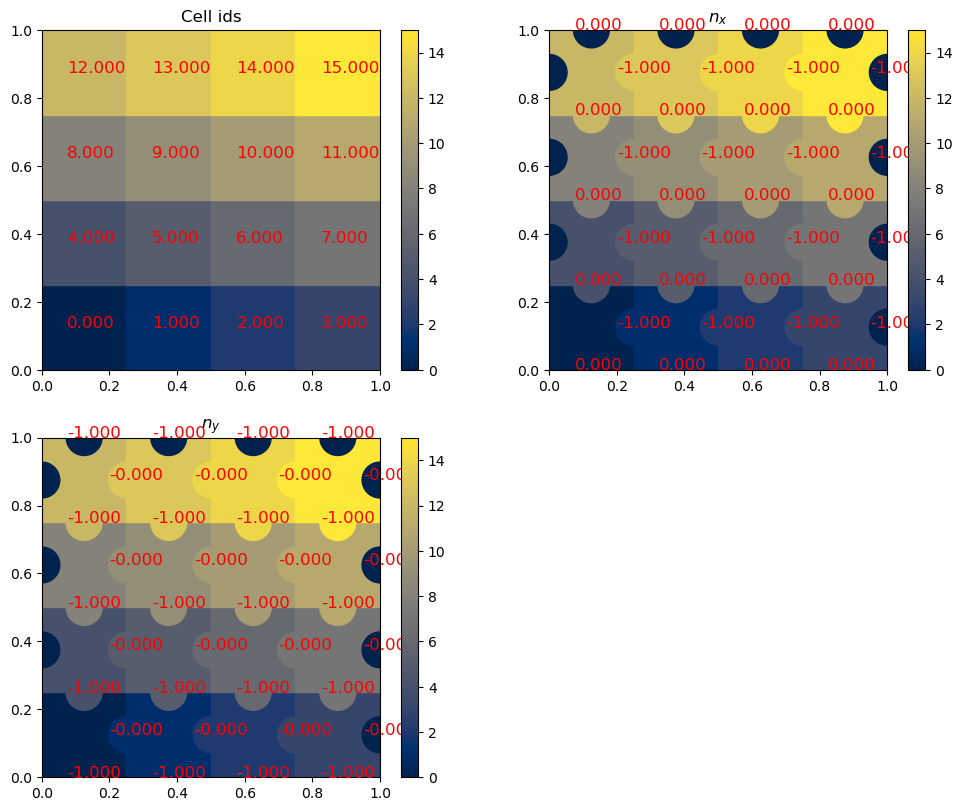

In [6]:
n_cells = mesh['cells']['n']
n_pairs = mesh['pairs']['n']

fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(3, 2, 1)
cells_id = np.arange(n_cells)
plot_cells(fig, ax, mesh, cells_id, title=r'Cell ids', xlim=(0., 1.), ylim=(0., 1.))

ax = fig.add_subplot(3, 2, 2)
x = pairs_centers[:, 0]
y = pairs_centers[:, 1]
values = mesh['pairs']['neighboring_cells']
n = n_pairs
scalar_map=plot_cells(fig, ax, mesh, cells_id, xlim=(0., 1.), ylim=(0., 1.), print_values=False)
for i, pair in enumerate(mesh['pairs']['neighboring_cells']):
    if 'Cell' in pair[0]:
        continue
    else:
        values[i][0] = {'Cell': -1}
values = [values[i][0]['Cell'] for i in range(n_pairs)]
cm = ax.scatter(x, y, c=values, cmap=scalar_map.get_cmap(), norm=scalar_map.norm, s=1./float(n_cells-1)*10000.)
ax.set_title(r'$n_x$')
# fig.colorbar(cm, ax=ax, label='edges')
for i in range(n):
    ax.annotate('{:.3f}'.format(mesh['pairs']['cells_normals'][i][0]), (x[i]-0.05, y[i]), fontsize=12, color='r')

ax = fig.add_subplot(3, 2, 3)
x = pairs_centers[:, 0]
y = pairs_centers[:, 1]
values = mesh['pairs']['neighboring_cells']
n = n_pairs
scalar_map=plot_cells(fig, ax, mesh, cells_id, xlim=(0., 1.), ylim=(0., 1.), print_values=False)
for i, pair in enumerate(mesh['pairs']['neighboring_cells']):
    if 'Cell' in pair[0]:
        continue
    else:
        values[i][0] = {'Cell': -1}
values = [values[i][0]['Cell'] for i in range(n_pairs)]
cm = ax.scatter(x, y, c=values, cmap=scalar_map.get_cmap(), norm=scalar_map.norm, s=1./float(n_cells-1)*10000.)
ax.set_title(r'$n_y$')
# fig.colorbar(cm, ax=ax, label='edges')
for i in range(n):
    ax.annotate('{:.3f}'.format(mesh['pairs']['cells_normals'][i][1]), (x[i]-0.05, y[i]), fontsize=12, color='r')


In [13]:
from poisson import poisson

boundaries= [('D', 0.), ('D', 1.), ('D', 1.), ('D', 2.)]
phi, phi_edges, grad_x, grad_y, grad_x_e, grad_y_e = poisson(mesh, boundaries)

fig = plt.figure(figsize=(12, 15))

n_cells = mesh['cells']['n']
n_pairs = mesh['pairs']['n']




ax = fig.add_subplot(3, 2, 1)
plot_cells(fig, ax, mesh, phi, title=r'$\Phi$', xlim=(0., 1.), ylim=(0., 1.))

ax = fig.add_subplot(3, 2, 2)
x = pairs_centers[:, 0]
y = pairs_centers[:, 1]
values = phi_edges
n = n_pairs
scalar_map=plot_cells(fig, ax, mesh, phi, xlim=(0., 1.), ylim=(0., 1.), print_values=False)
cm = ax.scatter(x, y, c=values, cmap=scalar_map.get_cmap(), norm=scalar_map.norm, s=1./float(n_cells-1)*10000.)
ax.set_title(r'$\Phi_{edges}$')
# fig.colorbar(cm, ax=ax, label='edges')
for i in range(n):
    ax.annotate('{:.3f}'.format(values[i]), (x[i]-0.05, y[i]), fontsize=12, color='r')

ax = fig.add_subplot(3, 2, 3)
plot_cells(fig, ax, mesh, grad_x, title=r'$\nabla \Phi_x$', xlim=(0., 1.), ylim=(0., 1.))

ax = fig.add_subplot(3, 2, 4)
plot_cells(fig, ax, mesh, grad_y, title=r'$\nabla \Phi_y$', xlim=(0., 1.), ylim=(0., 1.))

ax = fig.add_subplot(3, 2, 5)
x = pairs_centers[:, 0]
y = pairs_centers[:, 1]
values = grad_x_e
n = n_pairs
scalar_map=plot_cells(fig, ax, mesh, grad_x, xlim=(0., 1.), ylim=(0., 1.), print_values=False)
cm = ax.scatter(x, y, c=values, cmap=scalar_map.get_cmap(), norm=scalar_map.norm, s=1./float(n_cells-1)*10000.)
ax.set_title(r'$\nabla \Phi_{x,edges}$')
# fig.colorbar(cm, ax=ax, label='edges')
for i in range(n):
    ax.annotate('{:.3f}'.format(values[i]), (x[i]-0.05, y[i]), fontsize=12, color='r')
    
ax = fig.add_subplot(3, 2, 6)
x = pairs_centers[:, 0]
y = pairs_centers[:, 1]
values = grad_y_e
n = n_pairs
scalar_map=plot_cells(fig, ax, mesh, grad_y, xlim=(0., 1.), ylim=(0., 1.), print_values=False)
cm = ax.scatter(x, y, c=values, cmap=scalar_map.get_cmap(), norm=scalar_map.norm, s=1./float(n_cells-1)*10000.)
ax.set_title(r'$\nabla \Phi_{y,edges}$')
# fig.colorbar(cm, ax=ax, label='edges')
for i in range(n):
    ax.annotate('{:.3f}'.format(values[i]), (x[i]-0.05, y[i]), fontsize=12, color='r')

fig.tight_layout()

[[-16  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 -16  1  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 -18  1  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 -38  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 -8  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  1 -4  1  0  0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  1 -4  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  1 -24  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 -10  1  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0  1 -4  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0  1 -4  1  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  0  1 -26  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  1  0  0  0 -38  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  1 -32  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  1 -34  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  1 -60]]
[14 13 15 33  3  0  0 18  3  0  0 20 57 58 62 88]
1 16.168140633722214
2 9.585821150416546
3 10.573478869960285
4 10.732236692052533
5 10.763267435197825
6 10.7712644508763

ValueError: Did not converge